# Curve collapse of the Binder cumulant

In this example code, we will do a curve collapse analysis of the 2-state Potts (Ising) model using a radial basis function to parameterize the scaling function of the Binder cumulant $U_{4}$ and connected susceptibility $\chi$. Let's start with the Binder cumulant, defined as

$$U_{4}(K,N_{\mathrm{s}})=\frac{1}{2}\Bigg[3-\frac{\langle M^{4} \rangle}{\langle M^{2} \rangle^2}\Bigg],$$

where $M$ is the magnetization of the 2-state Potts model, $K$ is the inverse temperature, and $N_{\mathrm{s}}$ is the linear extent of the 2-dimensional lattice that we performed our simulation on. The anomalous dimension of the Binder cumulant is zero and the phase transition of the 2-state Potts model is 2nd-order. Therefore, within the vicinity of the transition temperature $K_{\mathrm{c}}$,

$$U_{4}(K,N_{\mathrm{s}})=\mathcal{F}_{U_{4}}\Big((K/K_{\mathrm{c}}-1)N_{\mathrm{s}}^{1/\nu}\Big),$$

where $\mathcal{F}_{U_{4}}$ is the universal scaling function of the Binder cumulant. Let's first import everything that we need to do the analysis.

In [1]:
""" External modules """
import gvar as gv # Peter Lepage's GVar module
import numpy as np # NumPy for number crunching

""" Local modules """
import example_tools # For getting example data

""" SwissFit modules """
from swissfit import fit # SwissFit fitter module
from swissfit.optimizers import scipy_basin_hopping # Basin hopping global optimizer
from swissfit.optimizers import scipy_least_squares # Trust region reflective local optimizer
from swissfit.machine_learning import radial_basis # Module for radial basis function network
from swissfit.empirical_bayes import single_parameter_surrogate # Empirical Bayes optimizer

Next, let's grab the data that we need over the range of temperatures $K_{\mathrm{l}}<K<K_{\mathrm{h}}$ and volumes that we wish to grab it at.

In [2]:
Kl, Kh = 1. / 2.3, 1. / 2.22 # K = J/T, where T is the standard Ising temp.
volumes = ['64', '96', '128', '256'] # Ns values
data, starting_parameters = example_tools.potts2_data('u', Kl, Kh, volumes)

The variable `data` is a dictionary. The `x` key contains input $(K,N_{\mathrm{s}})$ values and the `y` key contains GVar variables for $U_{4}(K,N_{\mathrm{s}})$. The `starting_parameters` variable is also a dictionary. It contains the starting parameters that we will use to initialize our first fit in the empirical Bayes analysis. 

Now that we have our data, let's create a radial basis function network (RBFN) object. First, we need to specify the topology of the radial basis function network. We'll create a network with a single hidden layer than possesses 2 nodes in its hidden layer.

In [3]:
network_topology = {
    'lyr1': { # Hidden layer
        'in': 1, 'out': 2, # Dimension of input & output
        'activation': 'exp', # Exponential activation
    },
    'lyr2': { # Output layer
        'in': 2, 'out': 1,
        'activation': 'linear' # Linear activation
    }
}

Now that we have specified the topology of the RBFN, we can pass it through the constructor of the radial basis network function class to create our RBFN.

In [4]:
neural_network = radial_basis.RadialBasisNeuralNetwork(network_topology)

Note that creating a feedforward neural network proceeds in almost exactly the same manner. Now that we have initialized our RBFN, let's create the fit function according, which is

$$U_{4}(K,N_{\mathrm{s}})=\mathrm{RBFN}\Big((K/K_{\mathrm{c}}-1)N_{\mathrm{s}}^{1/\nu}\Big)$$


In [5]:
def fit_fcn(b, l, p):
    return np.ravel(
        neural_network.out((b * p['c'][0] - 1.) * l**p['c'][1], p)
    )

The `out` method of the RBFN calculates the output of the RBFN full network given input `x` and RBFN parameters `p`. In this case, `x=(b * p['c'][0] - 1.) * l**p['c'][1]`. Next, we need to create a function that returns the fit priors and starting values for all parameters. We use ridge regression priors on the network weights that have a width $\lambda$.

In [6]:
def get_priors(lmbda):
    # Initialize dictionary of priors
    prior = {}
    
    # Prior on critical parameters K_c & 1/nu
    prior['c'] = [gv.gvar('2.0(2.0)'), gv.gvar('1.0(1.0)')]

    # Prior on the RBFN weights
    prior = neural_network.network_priors(
        prior_choice_weight = { # Prior for weights
            'lyr2': { # Only for output layer
                'prior_type': 'ridge_regression', # Type of prior
                'mean': 0., # Mean of zero
                'standard_deviation': lmbda # Width of lambda
            }
        }, 
        prior = prior # Take in already-specified prior dictionary and modify it
    )

    """ Return prior and p0 """
    return prior

We will call the function above every time that we want to do a new fit with a new value of $\lambda$. We are now ready to define a function that will take a value for the ridge regression parameter $\lambda$ and construct a SwissFit fitter object.

In [7]:
def create_swissfit_object(lmbda):
    # Get priors and starting values for parameters
    prior = get_priors(lmbda)

    # Define a function that transforms the priors into log priors to force positivity on critical parameters
    log_priors = {'c': lambda x: gv.log(x)}

    # Create SwissFit fit object
    fitter = fit.SwissFit(
        udata = data, # Fit data; "data = data" is also acceptable - "udata" means "uncorrelated"
        uprior = prior, # Priors; "prior = prior" is also acceptable - "uprior" means "uncorrelated"
        p0 = create_swissfit_object.p0, # Starting values for parameters - chained for empirical Bayes
        fit_fcn = fit_fcn, # Fit function
        prior_transformation_fcn = log_priors # Transformation of prior "c" to "log(c)"
    )

    # Return SwissFit object
    return fitter

# Initialize fit parameters (functions in Python can have attributes)
create_swissfit_object.p0 = gv.mean(starting_parameters) # Parameters of first fit in empirical Bayes

Each fit uses the basin hopping global optimization algorithm to perform a fit at a particular value of $\lambda$. Let's create a function that creates an object for the basin hopping optimizer with the modifications that we discuss in our paper.

In [8]:
def do_fit(lmbda, alpha = 1e-5, T = 1., niter_success = 100, niter = 100000, return_fit = False):
    """ Set fitter and trust region reflective local optimizer up """
    # Create SwissFit fitter
    fitter = create_swissfit_object(lmbda)

    """ Create local optimizer """
    # Create trust region reflective local optimizer from SciPy - fitter will save reference to local_optimizer for basin hopping
    local_optimizer = scipy_least_squares.SciPyLeastSquares(fitter = fitter)

    """ Create basin hopping global optimizer object """
    # Basin hopping global optimizer object instantiation
    global_optimizer = scipy_basin_hopping.BasinHopping(
        fitter = fitter, # Fit function is the "calculate_residual" method of fitter object
        optimizer_arguments = {
            'niter_success': niter_success, # Number of times Theta_best must remain the same for algorithm to terminate
            'niter': niter, # Maximum number of iterations of basin hopping algorithm
            'T': T, # Temperature hyperparameter
            'take_step': example_tools.create_take_step(alpha, fitter, scipy_basin_hopping) # Custom step taking function
        }
    )

    """ Do fit & return marginal likelihood """
    # Do fit
    fitter(global_optimizer)

    # Save this set of parameters so that next fit can pick them up as its initial parameters
    create_swissfit_object.p0 = gv.mean(fitter.p)

    # Return marginal likelihood
    if return_fit: return fitter
    else: return -fitter.logml

Now that we have a function that will perform a fit at a particular value of $\lambda$, we are ready to set up our empirical Bayes procedure. Here, we use the surrogate-based empirical Bayes method discussed in the paper. Let's create an object of the `SingleParameterSurrogate` class to do the empirical Bayes analysis.

In [9]:
emp_bayes_fit = single_parameter_surrogate.SingleParameterSurrogate(
    fcn = do_fit, # Our "do_fit" function that does the fit & calculates the marginal likelihood
    lb = 1.5, ub = 2.5, # Lower & upper bound on lambda
    n_points = 20, # Number of fits to perform
    spline_algorithm = 'cspline', # Use a smooth spline
)

Everything's together. All we need to do is run the empirical Bayes analysis. Let's go ahead and run it. Doing the whole empirical Bayes analysis may take a bit. If you want to monitor progress, add `'disp': true` to the `optimizer_arguments` dictionary when instantiating the `BasinHopping` class.

In [10]:
# Do empirical Bayes analysis
lambda_star = emp_bayes_fit().x[0]

# Fit data at lambda^{*} from empirical Bayes
fit_result = do_fit(lambda_star, return_fit = True)

# Print result of the fit
print(fit_result)

# Get critical parameters and print them
fit_parameters = fit_result.p
print('Tc, nu:', str(2. / fit_parameters['c'][0]) + ',', 1. / fit_parameters['c'][-1])


SwissFit: 🧀
   chi2/dof [dof] = 0.89 [24]   Q = 0.62   (Bayes) 
   chi2/dof [dof] = 0.98 [20]   Q = 0.48   (freq.) 
   AIC [k] = 37.57 [9]   logML = 147.086*

Parameters*:
     c
             1               2.269213(38)   [2.0(2.0)]
             2                 1.0005(27)   [1.0(1.0)]
     lyr1.center
             1                 -2.022(96)   [n/a]
             2                  -7.16(77)   [n/a]
     lyr1.bandwidth
             1                  0.510(44)   [n/a]
             2                  0.074(10)   [n/a]
     lyr2.weight
             1                 -0.236(34)   [0.0(1.8)]
             2                  -2.27(58)   [0.0(1.8)]
     lyr2.bias
             1                0.99720(20)   [n/a]

Estimator:
   algorithm = SciPy basin hopping
   minimization_failures = 0
   nfev = 669
   njev = 665
   fun = 10.62063066064723
   message = ['success condition satisfied']
   nit = 208
   success = True

*Laplace approximation

Tc, nu: 0.881363(15), 0.9995(27)


For the purposes of illustration, let's take repeat this analysis and look at the log of the marginal likelihood as a function of $\lambda$.

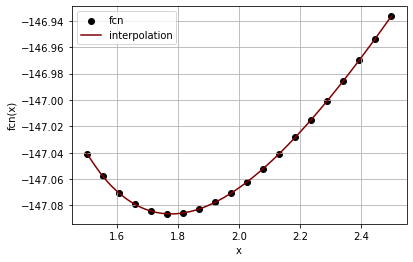

In [11]:
emp_bayes_fit.visualize_sample_points()

With that, we have done it. Let's go ahead and make a plot of our fit results. This won't look as nice and fancy as it did in the paper, but it'll give you a feel for what you can do with your fit results after the fit has been performed.

Text(0, 0.5, '$\\mathcal{F}_{U_{4}}(x)$')

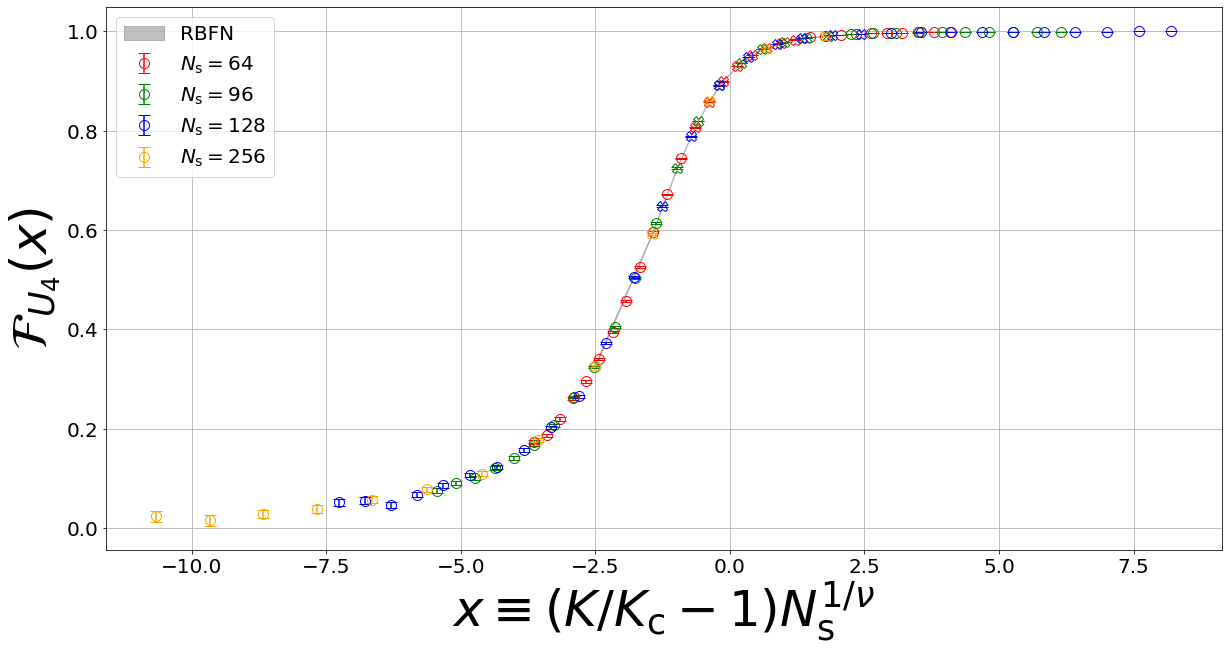

In [12]:
# Import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]
plt.close()

# Set figure information up
colors = {'64': 'red', '96': 'green', '128': 'blue', '256': 'orange'}

# Function that rescales input data
rescale_x = lambda b, l: gv.mean((b * fit_parameters['c'][0] - 1.) * l**fit_parameters['c'][-1])

# Plot scaling function for neural network
xrs = list(data['x'])
xrs.sort(key = lambda x: rescale_x(*x))
RBFN = fit_fcn(*np.transpose(xrs), fit_parameters)
plt.fill_between(
    [*map(lambda x: rescale_x(*x), xrs)],
    gv.mean(RBFN) - gv.sdev(RBFN),
    gv.mean(RBFN) + gv.sdev(RBFN),
    color = 'grey', alpha = 0.5,
    label = 'RBFN'
)

# Plot raw data in fit
vol_labels = []
for data_in_fit, marker in zip([False, True], ['o', 'X']):
    plot_data, _ = example_tools.potts2_data('u', Kl, Kh, volumes, data_in_fit = data_in_fit)
    for b, l, y in zip(*np.transpose(plot_data['x']), plot_data['y']):
        # Rescaled x
        xr = rescale_x(b, l)

        # Arguments for errorbar
        errorbar_args = {
            'fmt': marker, 'capsize': 6.,
            'color': colors[str(int(l))],
            'markerfacecolor': 'none',
            'markeredgecolor': colors[str(int(l))],
            'markersize': 10.
        }

        # Check if we should add a label
        if l not in vol_labels:
            errorbar_args['label'] = '$N_{\\mathrm{s}}=' + str(int(l)) + '$'
            vol_labels.append(l)
        
        # Plot as errorbar
        plt.errorbar(
            xr, gv.mean(y), gv.sdev(y), **errorbar_args
        )

plt.grid('on')
plt.legend(fontsize = 20.)
plt.gca().xaxis.set_tick_params(labelsize = 20.)
plt.gca().yaxis.set_tick_params(labelsize = 20.)
plt.xlabel('$x \\equiv (K/K_{\\mathrm{c}}-1)N_{\\mathrm{s}}^{1/\\nu}$', fontsize = 50.)
plt.ylabel('$\\mathcal{F}_{U_{4}}(x)$', fontsize = 50.)

# Curve collapse of the connected magnetic susceptiblity with a radial basis function network

Now that we've gotten our feet wet with the Binder cumulant, let's move on to the connected magnetic susceptibility $\chi$, defined as

$$\chi(K,N_{\mathrm{s}})=K N_{\mathrm{s}}^2 \big\langle (|M|-\langle |M| \rangle)^2 \big\rangle.$$

Within the vicinity of $K_{\mathrm{c}}$, the connected magnetic suscptibility scales as

$$\chi(K,N_{\mathrm{s}})= N_{\mathrm{s}}^{\gamma/\nu} \mathcal{F}_{\chi}\Big((K/K_{\mathrm{c}}-1)N_{\mathrm{s}}^{1/\nu}\Big).$$

The critical exponents $\gamma,\nu$ are related to the critical exponent of the wave function $\eta$ as $\gamma/\nu=2-\eta$. In the paper, $\eta$ is what we reported. Since I've already taken you through the analysis of the Binder cumulant step-by-step, let's throw the whole analysis together in one block. 

In [16]:
""" Get the data """
Kl, Kh = 1. / 2.3, 1. / 2.22 # K = J/T, where T is the standard Ising temp.
volumes = ['64', '96', '128', '256'] # Ns values
data, starting_parameters = example_tools.potts2_data('sus', Kl, Kh, volumes)
create_swissfit_object.p0 = gv.mean(starting_parameters)

""" Create the radial basis function network """
network_topology = {
    'lyr1': { # Hidden layer
        'in': 1, 'out': 3, # Dimension of input & output
        'activation': 'exp', # Exponential activation
    },
    'lyr2': { # Output layer
        'in': 3, 'out': 1,
        'activation': 'linear' # Linear activation
    }
}
neural_network = radial_basis.RadialBasisNeuralNetwork(network_topology)

""" Define the fit function """
def fit_fcn(b, l, p):
    return np.ravel(
        neural_network.out((b * p['c'][0] - 1.) * l**p['c'][1], p)
    ) * l**(p['c'][-1] / p['c'][1]) # gamma / nu

""" Define a function that grabs the priors """
def get_priors(lmbda):
    # Initialize dictionary of priors
    prior = {}
    
    # Prior on critical parameters K_c & 1/nu
    prior['c'] = [gv.gvar('2.0(2.0)'), gv.gvar('1.0(1.0)'), gv.gvar('1.0(1.0)')]

    # Prior on the RBFN weights
    prior = neural_network.network_priors(
        prior_choice_weight = { # Prior for weights
            'lyr2': { # Only for output layer
                'prior_type': 'ridge_regression', # Type of prior
                'mean': 0., # Mean of zero
                'standard_deviation': lmbda # Width of lambda
            }
        }, 
        prior = prior # Take in already-specified prior dictionary and modify it
    )

    """ Return prior and p0 """
    return prior

""" Define function that creates SwissFit object """
def create_swissfit_object(lmbda):
    # Get priors and starting values for parameters
    prior = get_priors(lmbda)

    # Define a function that transforms the priors into log priors to force positivity on critical parameters
    log_priors = {'c': lambda x: gv.log(x)}

    # Create SwissFit fit object
    fitter = fit.SwissFit(
        udata = data, # Fit data; "data = data" is also acceptable - "udata" means "uncorrelated"
        uprior = prior, # Priors; "prior = prior" is also acceptable - "uprior" means "uncorrelated"
        p0 = create_swissfit_object.p0, # Starting values for parameters - chained for empirical Bayes
        fit_fcn = fit_fcn, # Fit function
        prior_transformation_fcn = log_priors # Transformation of prior "c" to "log(c)"
    )

    # Return SwissFit object
    return fitter

# Initialize fit parameters (functions in Python can have attributes)
create_swissfit_object.p0 = gv.mean(starting_parameters) # Parameters of first fit in empirical Bayes

print(starting_parameters)

""" Define function to do fit and grab marginal likelihood """
def do_fit(lmbda, alpha = 1e-5, T = 1., niter_success = 100, niter = 100000, return_fit = False):
    """ Set fitter and trust region reflective local optimizer up """
    # Create SwissFit fitter
    fitter = create_swissfit_object(lmbda)

    """ Create local optimizer """
    # Create trust region reflective local optimizer from SciPy - fitter will save reference to local_optimizer for basin hopping
    local_optimizer = scipy_least_squares.SciPyLeastSquares(fitter = fitter)

    """ Create basin hopping global optimizer object """
    # Basin hopping global optimizer object instantiation
    global_optimizer = scipy_basin_hopping.BasinHopping(
        fitter = fitter, # Fit function is the "calculate_residual" method of fitter object
        optimizer_arguments = {
            'niter_success': niter_success, # Number of times Theta_best must remain the same for algorithm to terminate
            'niter': niter, # Maximum number of iterations of basin hopping algorithm
            'T': T, # Temperature hyperparameter
            'take_step': example_tools.create_take_step(alpha, fitter, scipy_basin_hopping) # Custom step taking function
        }
    )

    """ Do fit & return marginal likelihood """
    # Do fit
    fitter(global_optimizer)

    # Save this set of parameters so that next fit can pick them up as its initial parameters
    create_swissfit_object.p0 = gv.mean(fitter.p)

    # Return marginal likelihood
    if return_fit: return fitter
    else: return -fitter.logml

""" Do empirical Bayes analysis """
# Set up empirical Bayes
emp_bayes_fit = single_parameter_surrogate.SingleParameterSurrogate(
    fcn = do_fit, # Our "do_fit" function that does the fit & calculates the marginal likelihood
    lb = 1.5, ub = 2.5, # Lower & upper bound on lambda
    n_points = 20, # Number of fits to perform
    spline_algorithm = 'cspline', # Use a smooth spline
)

# Do empirical Bayes analysis
lambda_star = emp_bayes_fit().x[0]

# Fit data at lambda^{*} from empirical Bayes
fit_result = do_fit(lambda_star, return_fit = True)

# Print result of the fit
print(fit_result)

# Get critical parameters and print them
fit_parameters = fit_result.p
print('Tc, nu:', str(2. / fit_parameters['c'][0]) + ',', 1. / fit_parameters['c'][1], 2. - fit_parameters['c'][-1] /  fit_parameters['c'][1])

{'c': [2.269211(70), 1.0021(39), 1.7466(72)], 'lyr1.center': [-0.7275(71), 1.122(19), -1.5991(74)], 'lyr1.bandwidth': [0.852(11), -258.939624238(78), -0.2051(26)], 'lyr2.weight': [0.0228(10), 0.0024(10), 0.0274(11)], 'lyr2.bias': [0.001517(63)]}

SwissFit: 🧀
   chi2/dof [dof] = 0.9 [22]   Q = 0.59   (Bayes) 
   chi2/dof [dof] = 1.22 [16]   Q = 0.24   (freq.) 
   AIC [k] = 45.57 [13]   logML = -71.993*

Parameters*:
     c
             1               2.269211(72)   [2.0(2.0)]
             2                 1.0021(40)   [1.0(1.0)]
             3                 1.7540(79)   [1.0(1.0)]
     lyr1.center
             1                 -0.727(27)   [n/a]
             2                  1.121(27)   [n/a]
             3                  -1.60(13)   [n/a]
     lyr1.bandwidth
             1                  0.852(72)   [n/a]
             2                 -426(8745)   [n/a]
             3                 -0.205(28)   [n/a]
     lyr2.weight
             1                 0.0228(30)   [0.0(1.5)]


Great, now that we're done, let's go ahead and see what the result of our fit looks like.

Text(0, 0.5, '$\\mathcal{F}_{\\chi}(x)$')

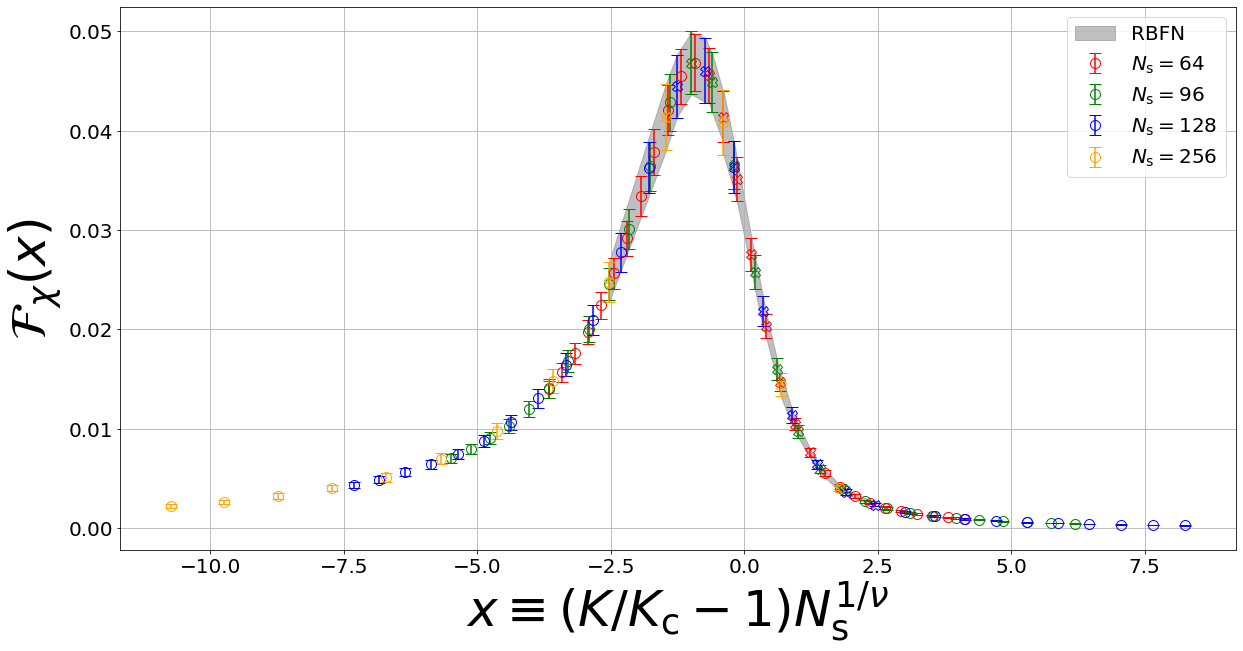

In [17]:
# Import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]
plt.close()

# Set figure information up
colors = {'64': 'red', '96': 'green', '128': 'blue', '256': 'orange'}

# Function that rescales input data
rescale_x = lambda b, l: gv.mean((b * fit_parameters['c'][0] - 1.) * l**fit_parameters['c'][1])

# Plot scaling function for neural network
xrs = list(data['x'])
xrs.sort(key = lambda x: rescale_x(*x))
RBFN = fit_fcn(
    *np.transpose(xrs), 
    fit_parameters
) / np.transpose(xrs)[-1]**(fit_parameters['c'][1] * fit_parameters['c'][-1])
plt.fill_between(
    [*map(lambda x: rescale_x(*x), xrs)],
    gv.mean(RBFN) - gv.sdev(RBFN),
    gv.mean(RBFN) + gv.sdev(RBFN),
    color = 'grey', alpha = 0.5,
    label = 'RBFN'
)

# Plot raw data in fit
vol_labels = []; old_data = data;
for data_in_fit, marker in zip([False, True], ['o', 'X']):
    if not data_in_fit:
        plot_data, _ = example_tools.potts2_data('sus', Kl, Kh, volumes, data_in_fit = data_in_fit)
    else: plot_data = fit_result.data
    for b, l, y in zip(*np.transpose(plot_data['x']), plot_data['y']):
        # Rescaled x
        xr = rescale_x(b, l)

        # Rescaled y
        y /= l**(fit_parameters['c'][1] * fit_parameters['c'][-1])
        # Arguments for errorbar
        errorbar_args = {
            'fmt': marker, 'capsize': 6.,
            'color': colors[str(int(l))],
            'markerfacecolor': 'none',
            'markeredgecolor': colors[str(int(l))],
            'markersize': 10.
        }

        # Check if we should add a label
        if l not in vol_labels:
            errorbar_args['label'] = '$N_{\\mathrm{s}}=' + str(int(l)) + '$'
            vol_labels.append(l)
        
        # Plot as errorbar
        plt.errorbar(
            xr, gv.mean(y), gv.sdev(y), **errorbar_args
        )

plt.grid('on')
plt.legend(fontsize = 20.)
plt.gca().xaxis.set_tick_params(labelsize = 20.)
plt.gca().yaxis.set_tick_params(labelsize = 20.)
plt.xlabel('$x \\equiv (K/K_{\\mathrm{c}}-1)N_{\\mathrm{s}}^{1/\\nu}$', fontsize = 50.)
plt.ylabel('$\\mathcal{F}_{\chi}(x)$', fontsize = 50.)

# Curve collapse of the connected magnetic susceptiblity with polynomial ansatz

Now that we've given curve collapse with an RBFN a go, let's try out doing the same curve collapse with a polynomial

$$\mathcal{P}(x)=\sum_{i=0}^{N-1}p_{i}x^{i}$$

We use the ridge regression prior

$$\chi^2_{\mathrm{poly. \ ridge}}=\frac{1}{\lambda^2}\sum_{i=0}^{N-1}p_i^2.$$

As far as SwissFit is concerned, much of the code is the same as it was for the radial basis function network, just without the extra code requried to get the RBFN up and running, of course. Let's throw it all down in the next cell.

In [15]:
""" Get the data """
Kl, Kh = 1. / 2.3, 1. / 2.22 # K = J/T, where T is the standard Ising temp.
volumes = ['64', '96', '128', '256'] # Ns values
data, _ = example_tools.potts2_data('sus', Kl, Kh, volumes)

""" Define the fit function """
def fit_fcn(b, l, p):
    return gv.powerseries.PowerSeries(p['p'])(
        (b * p['c'][0] - 1.) * l**p['c'][1]
    ) * l**(p['c'][-1] / p['c'][1]) # gamma / nu

""" Define a function that grabs the priors """
def get_priors(lmbda):
    # Total number of polynomial fit parameters
    N = 10
    
    # Initialize dictionary of priors
    prior = {}
    
    # Prior on critical parameters K_c & 1/nu
    prior['c'] = [gv.gvar('2.0(2.0)'), gv.gvar('1.0(1.0)'), gv.gvar('1.0(1.0)')]

    # Prior on the RBFN weights
    prior['p'] = [gv.gvar(0., lmbda) for pi in range(N)]

    """ Return prior and p0 """
    return prior

""" Define function that creates SwissFit object """
def create_swissfit_object(lmbda):
    # Get priors and starting values for parameters
    prior = get_priors(lmbda)

    # Define a function that transforms the priors into log priors to force positivity on critical parameters
    log_priors = {'c': lambda x: gv.log(x)}

    # Create SwissFit fit object
    fitter = fit.SwissFit(
        udata = data, # Fit data; "data = data" is also acceptable - "udata" means "uncorrelated"
        uprior = prior, # Priors; "prior = prior" is also acceptable - "uprior" means "uncorrelated"
        p0 = create_swissfit_object.p0 if create_swissfit_object.p0 is not None else {}, # Starting values for parameters - chained for empirical Bayes
        fit_fcn = fit_fcn, # Fit function
        prior_transformation_fcn = log_priors # Transformation of prior "c" to "log(c)"
    )

    # Return SwissFit object
    return fitter

# Initialize fit parameters (functions in Python can have attributes)
create_swissfit_object.p0 = None

""" Define function to do fit and grab marginal likelihood """
def do_fit(lmbda, alpha = 1e-1, T = 1., niter_success = 100, niter = 100000, return_fit = False):
    """ Set fitter and trust region reflective local optimizer up """
    # Create SwissFit fitter
    fitter = create_swissfit_object(lmbda)

    """ Create local optimizer """
    # Create trust region reflective local optimizer from SciPy - fitter will save reference to local_optimizer for basin hopping
    local_optimizer = scipy_least_squares.SciPyLeastSquares(fitter = fitter)

    """ Create basin hopping global optimizer object """
    # Basin hopping global optimizer object instantiation
    global_optimizer = scipy_basin_hopping.BasinHopping(
        fitter = fitter, # Fit function is the "calculate_residual" method of fitter object
        optimizer_arguments = {
            'niter_success': niter_success, # Number of times Theta_best must remain the same for algorithm to terminate
            'niter': niter, # Maximum number of iterations of basin hopping algorithm
            'T': T, # Temperature hyperparameter
            'take_step': example_tools.create_take_step(alpha, fitter, scipy_basin_hopping) # Custom step taking function
        }
    )

    """ Do fit & return marginal likelihood """
    # Do fit
    fitter(global_optimizer)

    # Save this set of parameters so that next fit can pick them up as its initial parameters
    create_swissfit_object.p0 = gv.mean(fitter.p)

    # Return marginal likelihood
    if return_fit: return fitter
    else: return -fitter.logml

""" Do empirical Bayes analysis """
# Set up empirical Bayes
emp_bayes_fit = single_parameter_surrogate.SingleParameterSurrogate(
    fcn = do_fit, # Our "do_fit" function that does the fit & calculates the marginal likelihood
    lb = 0.005, ub = 0.025, # Lower & upper bound on lambda
    n_points = 20, # Number of fits to perform
    spline_algorithm = 'steffen', # Use a monotonic spline
)

# Do empirical Bayes analysis
lambda_star = emp_bayes_fit().x[0]

# Fit data at lambda^{*} from empirical Bayes
fit_result = do_fit(lambda_star, return_fit = True)

# Print result of the fit
print(fit_result)

# Get critical parameters and print them
fit_parameters = fit_result.p
print('Tc, nu:', str(2. / fit_parameters['c'][0]) + ',', 1. / fit_parameters['c'][1], 2. - fit_parameters['c'][-1] * fit_parameters['c'][1])

/tmp/ipykernel_220212/1833514491.py:35: RuntimeWarning: invalid value encountered in log
  log_priors = {'c': lambda x: gv.log(x)}


Warning! ValueError in local optimization.
Warning! ValueError in local optimization.
Warning! ValueError in local optimization.
Warning! ValueError in local optimization.
Warning! ValueError in local optimization.
Warning! ValueError in local optimization.
Warning! ValueError in local optimization.
Warning! ValueError in local optimization.

SwissFit: 🧀
   chi2/dof [dof] = 1.31 [29]   Q = 0.12   (Bayes) 
   chi2/dof [dof] = 1.76 [16]   Q = 0.03   (freq.) 
   AIC [k] = 54.11 [13]   logML = -112.362*

Parameters*:
     c
             1                2.26907(15)   [2.0(2.0)]
             2                 1.0087(63)   [1.0(1.0)]
             3                 1.7608(89)   [1.0(1.0)]
     p
             1                0.03277(64)   [0.000(14)]
             2               -0.02829(72)   [0.000(14)]
             3               -0.00089(38)   [0.000(14)]
             4                0.01078(91)   [0.000(14)]
             5               -0.00244(36)   [0.000(14)]
             6        